# Customer Segmentation & Market Basket Analysis

The dataset has been obtained from UCI Machine Learning Repository. It comprises of the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.The company mainly sells unique all-occasion gifts. Many customers of the company are wholesalers.

#### Link for dataset: https://archive.ics.uci.edu/ml/datasets/online+retail#


In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from itertools import combinations
from collections import Counter

## Reading dataset

In [2]:
data=pd.read_excel('OnlineRetail.xlsx')

In [3]:
print("Shape of dataset:",data.shape)
data.head()

Shape of dataset: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
data.info() #to see the number of non null objects in the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


The CustomerID column of the dataset has null values so they need to be removed such that all the columns have equal number of rows.

In [5]:
data=data.dropna()#dropping the NA values from the dataset

In [6]:
print('Shape of dataset after removing missing values:',data.shape)

Shape of dataset after removing missing values: (406829, 8)


In [7]:
#finding the total number of days in the dataset
print('The dataset comprises of:',data.InvoiceDate.max()-data.InvoiceDate.min())

The dataset comprises of: 373 days 04:24:00


In [8]:
data.describe()# to see the minimum and maximum values stored in the dataset

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


The minimum of the Quantity column has negative values due to cancelled transactions. Also, the UnitPrice has some 0 entries which can be assumed to be free products given to customers as a part of promotion.

In [9]:
# extracting the year_month from InvoiceDate column 
data.loc[:,'Year_Month']=data['InvoiceDate'].apply(lambda s: s.strftime('%Y-%m'))

In [10]:
#finding the expense by multplying the price of product i.e. UnitPrice column with the quantity i.e. Quantity column that was bought
data['Expense'] =data.apply(lambda row: row['UnitPrice'] * row['Quantity'], axis=1)

In [11]:
data.head()#observing the changes in dataset

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year_Month,Expense
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34


We can see that two new columns i.e. Year_Month and Expense have been added to the dataset.

As the dataset contains some cancelled transactions, we create another dataset with just the cancelled transactions. The cancelled transactions can be identified by InvoiceNo entries beginning with letter 'c'.

## Looking at the cancelled transactions

In [12]:
candata = data[data['InvoiceNo'].str.startswith('c')==False]# finding all the cancelled transactions

In [13]:
candata.describe()

,Quantity,UnitPrice,CustomerID,Expense
count,8905.000000,8905.000000,8905.000000,8905.000000
mean,-30.859966,18.845519,14991.667266,-68.651554
std,1170.154939,444.366043,1706.772357,2019.177682
min,-80995.000000,0.010000,12346.000000,-168469.600000
25%,-6.000000,1.450000,13510.000000,-17.000000
50%,-2.000000,2.950000,14895.000000,-8.500000
75%,-1.000000,4.950000,16393.000000,-3.300000
max,-1.000000,38970.000000,18282.000000,-0.120000


With the information from cancelled data it is difficult to find why orders were cancelled so we can analyse the cancelled data information separately.

In [14]:
candata.groupby(['Description'])
print('Total number of cancelled transactions=',len(candata['InvoiceNo'].value_counts()))

Total number of cancelled transactions= 3654


### Top 10 products that were cancelled after ordering

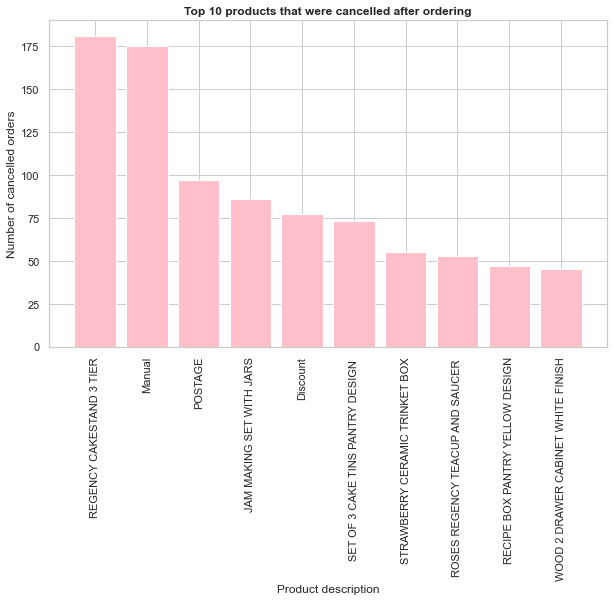

In [99]:
can_orders = candata['Description'].value_counts().sort_values(ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(can_orders.iloc[0:10].index,can_orders.iloc[0:10].values,color='pink')
plt.xticks(rotation=90)
plt.ylabel("Number of cancelled orders")
plt.xlabel("Product description")
plt.title("Top 10 products that were cancelled after ordering",fontweight="bold")
plt.show()

It is observed that the top 5 products that were cancelled after purchasing are Regency Cakestand 3 Tier, Manual, Postage, Jam making set with jars and Discount. We should not take discount into consideration as a part of cancelled orders. The online retail store needs to look further in depth regarding why the orders for items like Regency Cakestand 3 Tier,Jam making set with jars, Strawberry ceramic trinket box, etc. were getting cancelled. There could be various possibilities like product has some manufacturing defect, product did not match the description as listed by the store, customer received a broken product in case of fragile products, etc.

### Finding the countries from where most number of orders were cancelled

In [16]:
candata['Country'].value_counts(sort=True)

United Kingdom        7533
Germany                453
EIRE                   247
France                 149
USA                    112
Australia               74
Spain                   48
Italy                   45
Belgium                 38
Japan                   37
Switzerland             35
Portugal                18
Malta                   15
Norway                  14
Poland                  11
Sweden                  11
Channel Islands         10
Finland                 10
Denmark                  9
Cyprus                   8
Netherlands              8
Singapore                7
Czech Republic           5
Austria                  3
Israel                   2
Saudi Arabia             1
European Community       1
Greece                   1
Name: Country, dtype: int64

The most number of cancelled orders were from United Kingdom, Germany, EIRE, France and USA.

## Cleaning data

It was observed earlier that the minimum value of quantity was negative in case of cancelled transactions and it is not 
possible to have quantity negative so we will get rid of all the data where quantity is negative

In [17]:
data = data[data['Quantity'] > 0] 

In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397924 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  object        
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  float64       
 7   Country      397924 non-null  object        
 8   Year_Month   397924 non-null  object        
 9   Expense      397924 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(5)
memory usage: 33.4+ MB


Now,we can see that the dataset has same number of rows and there are no null values as well in the dataset.

We can see that the InvoiceDate column is in datetime64[ns] format, thus we can extract Date and Time.

In [19]:
data['Date']=data['InvoiceDate'].dt.date# extracting date
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year_Month,Expense,Date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12,15.30,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12,22.00,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12,20.34,2010-12-01


In [20]:
print('Total customers in database=',len(data['CustomerID'].value_counts()))
print('Total number of transactions=',len(data['InvoiceNo'].value_counts()))

Total customers in database= 4339
Total number of transactions= 18536


## Exploratory Data Analysis

### Countries that purchased most

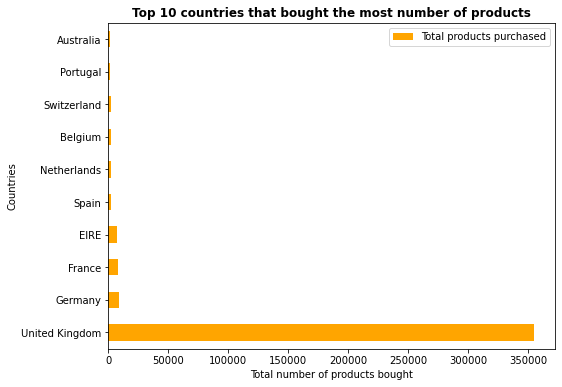

In [21]:
plt.figure(figsize=(8, 6))
data['Country'].value_counts()[:10].plot(kind='barh',color='orange')
plt.legend(labels = ['Total products purchased'])
plt.title('Top 10 countries that bought the most number of products',fontweight="bold")
plt.ylabel('Countries')
plt.xlabel('Total number of products bought')
plt.show()

We can observe that the top 5 customers of the company are from United Kingdom, Germany, France, EIRE and Spain. Majority of customers for the retail store seem to be from United Kingdom itself where the store is based.

#### Percentage of purchases made by top 3 countries

In [22]:
print('Percentage of purchase done by customers from UK=',data.loc[data.Country=="United Kingdom"].shape[0] / data.shape[0] * 100,'%')
print('Percentage of purchase done by customers from Germany=',data.loc[data.Country=="Germany"].shape[0] / data.shape[0] * 100,'%')
print('Percentage of purchase done by customers from France=',data.loc[data.Country=="France"].shape[0] / data.shape[0] * 100,'%')

Percentage of purchase done by customers from UK= 89.04841125441038 %
Percentage of purchase done by customers from Germany= 2.2722932017169106 %
Percentage of purchase done by customers from France= 2.096380213307064 %


### Monthly Sales

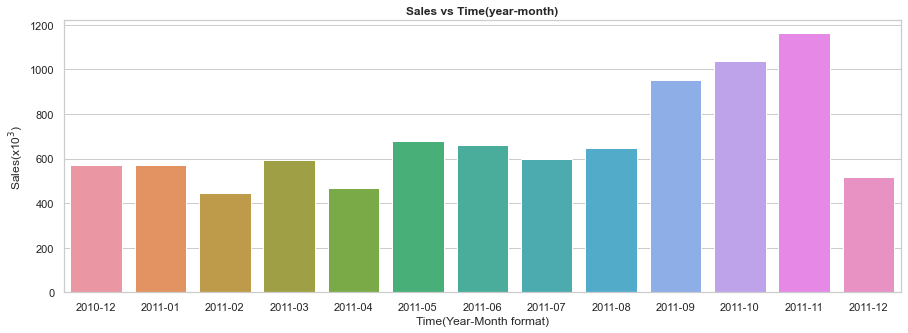

In [90]:
sales = pd.DataFrame(data.groupby(['Year_Month'])['Expense'].sum()).reset_index()
sales.head()
plt.figure(figsize=(15,5))
plt.grid(True)
ax=sns.barplot(x=sales.Year_Month,y=(sales.Expense)/1000)
plt.xlabel('Time(Year-Month format)')
plt.ylabel('Sales(x10$^3$)')
plt.title('Sales vs Time(year-month)',fontweight="bold")
plt.show()

#### Best month of sales

The sales for the store were the highest for November 2011.

In [24]:
print('Sales made in the month of November 2011:',sales.iloc[11,1])

Sales made in the month of November 2011: 1161817.3800000001


### Customers who purchased the most number of products

Text(0.5, 1.0, 'Customers who bought the most number of products')

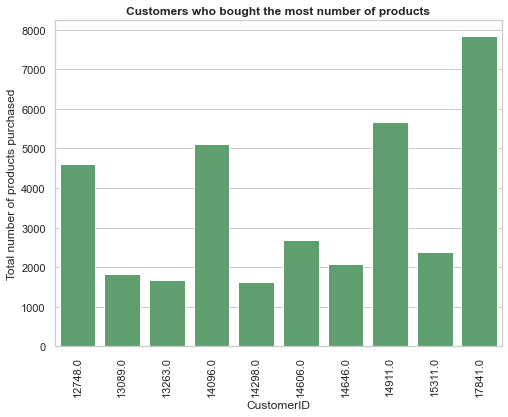

In [25]:
customer = data.CustomerID.value_counts().sort_values(ascending=False) 
plt.figure(figsize=(8, 6))
sns.set_theme(style="whitegrid")
sns.barplot(x=customer.iloc[0:10].index, y=customer.iloc[0:10].values, color="g")
plt.xticks(rotation=90)
plt.ylabel("Total number of products purchased")
plt.xlabel("CustomerID")
plt.title('Customers who bought the most number of products',fontweight="bold")

From this chart we can see that certain customers like 17841.0,  14911.0, 14096.0 seem to be wholesale retailers who make big purchases from the online retail store.

### Quantity of products sold every month

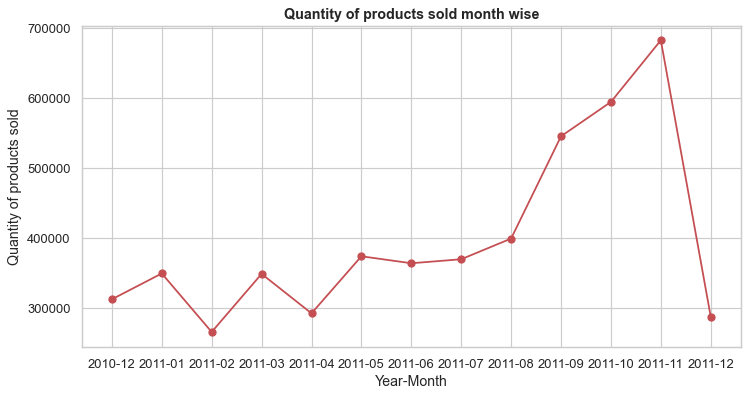

In [26]:
products= pd.DataFrame(data.groupby('Year_Month').Quantity.sum()).reset_index()
plt.figure(figsize=(10,5), dpi=85)
plt.grid(True)
plt.plot(products.Year_Month,products.Quantity,color='r',marker='o')
plt.title('Quantity of products sold month wise',fontweight="bold")
plt.xlabel('Year-Month')
plt.ylabel('Quantity of products sold')
plt.show()

#### Most number of products sold

From the line chart above, we can see that the most number of products were sold in November,2011.

In [27]:
print('Total number of products sold in the month of November 2011:',products.iloc[11,1])

Total number of products sold in the month of November 2011: 681888


### Products which are often bought together

In [98]:
new=data[data['InvoiceNo'].duplicated(keep=False)]
new.loc[:,'FrequentlyBought']=new.groupby('InvoiceNo')['Description'].transform(lambda s: ','.join(s))
new=new[['InvoiceNo','FrequentlyBought']].drop_duplicates()
# new=new.reset_index()

In [32]:
c=Counter()
for i in new['FrequentlyBought']:
    list_rows=i.split(',')
    c.update(Counter(combinations(list_rows,2)))


In [33]:
c.most_common(10)

[(('KEY FOB ', 'KEY FOB '), 643),
 (('KEY FOB ', ' BACK DOOR '), 451),
 (('GREEN REGENCY TEACUP AND SAUCER', 'PINK REGENCY TEACUP AND SAUCER'), 444),
 (('KEY FOB ', ' SHED'), 425),
 (('KEY FOB ', ' FRONT  DOOR '), 350),
 (('LUNCH BAG RED RETROSPOT', 'LUNCH BAG PINK POLKADOT'), 327),
 (('LUNCH BAG RED RETROSPOT', 'LUNCH BAG  BLACK SKULL.'), 316),
 (('JUMBO BAG PINK POLKADOT', 'JUMBO BAG RED RETROSPOT'), 315),
 (('ROSES REGENCY TEACUP AND SAUCER ', 'GREEN REGENCY TEACUP AND SAUCER'),
  314),
 (('GREEN REGENCY TEACUP AND SAUCER', 'ROSES REGENCY TEACUP AND SAUCER '),
  304)]

From the above list, we can see that key fob is usually purchased with key fob and this has happened 643 times. Also, key fob and back door were the second highest selling product purchased togehter.

### Finding the hour of the day at which sales are maximum

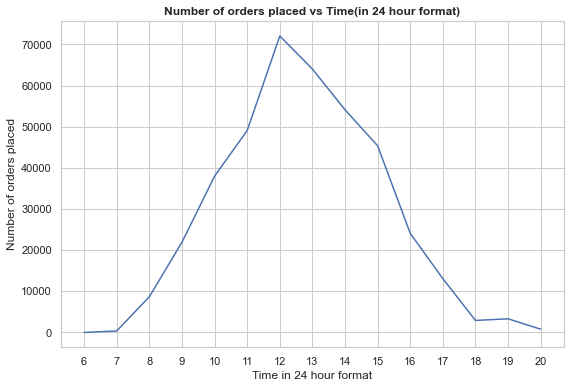

In [34]:
data['Hour']=data['InvoiceDate'].dt.hour
hourly=data.groupby(['Hour']).Quantity.count()
hourdata=[hour for hour, df in data.groupby('Hour') ]
plt.figure(figsize=(9, 6))
sns.lineplot(x=hourdata,y=hourly,palette="flare")
plt.xticks(hourdata)
plt.grid(True)
plt.title('Number of orders placed vs Time(in 24 hour format)',fontweight="bold")
plt.xlabel('Time in 24 hour format')
plt.ylabel('Number of orders placed')
plt.show()

From the above plot it can be seen that the sales are highest at 12 PM and lowest from 8 PM to 7 AM.A second peak in sales is observed at 3 PM.

The retail store can utilize this by advertising about the products a little early before the sales begin to rise. Approximately around 10 AM, it can start the advertisement on various platforms. The advertisements can be shown again before there is a second peak of sales, i.e. around 2:30 PM.

### Product that was sold the most

In [35]:
mostsold=pd.DataFrame(data.groupby('Description').agg({'Quantity': lambda s: s.sum()}))
mostsold=mostsold.sort_values(by=['Quantity'],ascending=False)
mostsold=mostsold.reset_index()

#### List of 10 highest selling products

In [36]:
mostsold.head(10)

,Description,Quantity
0,"PAPER CRAFT , LITTLE BIRDIE",80995
1,MEDIUM CERAMIC TOP STORAGE JAR,77916
2,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54415
3,JUMBO BAG RED RETROSPOT,46181
4,WHITE HANGING HEART T-LIGHT HOLDER,36725
5,ASSORTED COLOUR BIRD ORNAMENT,35362
6,PACK OF 72 RETROSPOT CAKE CASES,33693
7,POPCORN HOLDER,30931
8,RABBIT NIGHT LIGHT,27202
9,MINI PAINT SET VINTAGE,26076


#### List of 10 least selling products

In [37]:
mostsold.tail(10)

,Description,Quantity
3867,SILVER AND BLACK ORBIT NECKLACE,1
3868,ORANGE FELT VASE + FLOWERS,1
3869,CRACKED GLAZE EARRINGS RED,1
3870,CRACKED GLAZE EARRINGS BROWN,1
3871,PACK 4 FLOWER/BUTTERFLY PATCHES,1
3872,BLACK VINT ART DEC CRYSTAL BRACELET,1
3873,FLOWER SHOP DESIGN MUG,1
3874,SET 36 COLOURING PENCILS DOILEY,1
3875,HEN HOUSE W CHICK IN NEST,1
3876,AMBER BERTIE GLASS BEAD BAG CHARM,1


There are different ways to analyse and find a technique to segment customers like custom (as per business model requirements), RFM Analysis, Pareto cut,etc. Here, RFM Analysis is used to segment customers into different clusters.

## RFM Analysis

RFM Analysis is a technique used by companies to segment their customers into different clusters based on 3 main parameters: Recency, Frequency and Monetary. Based on these parameters a score is assigned to each customer and is alloted a cluster. Using this method, companies can segment customers and understand their purchasing patterns for target advertising. Thus, marketing campaigns can be tailored as per the customer and resources can be saved.

### Recency

Recency takes into account the customer's past purchase with respect to the first purchase. It means that a customer .In this case, Recency is measured in terms of days. A customer who has made a purchase recently is more likely to come in future for another purchase.

In [38]:
print('The data collection begins from date: ',data.InvoiceDate.max())
print('The data collection ends on date:',data.InvoiceDate.min())

The data collection begins from date:  2011-12-09 12:50:00
The data collection ends on date: 2010-12-01 08:26:00


In all the cases, i.e. Recency, Frequency and Monetary, the time period we will consider begins from 2011-12-09 12:50:00 till 2010-12-01 08:26:00. 

In [39]:
end=data.InvoiceDate.max().date()
recency =data.groupby('CustomerID').agg({'Date':lambda s: (end - s.max()).days})

### Frequency

Frequency is used to observe how frequently a customer purchases items from the company in particular period of time. This can be found by calculating the total number of transactions of each customer.

In [40]:
freq= data.groupby('CustomerID').agg({'InvoiceNo': lambda x:len(x)})

### Monetary

Monetary is used to indicate the amount that a customer spends by purchasing items at the retail store during a fixed period of time. It can be found by calculating the total amount spent by a customer in all his purchases.

In [41]:
monetary=data.groupby('CustomerID').agg({'Expense': lambda s: s.sum()})

### RFM Table

In [42]:
rf=pd.merge(recency,freq, on='CustomerID')# merging Recency and Frequency first based on CustomerID
rfm=pd.merge(rf,monetary, on='CustomerID')#merging Recency, Frequency together with Monetary based on CustomerID

In [43]:
rfm.rename(columns= {'Date': 'Recency','InvoiceNo': 'Frequency','Expense': 'Monetary'}, inplace= True)# renaming columns

In [44]:
rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12347.0,2,182,4310.00
12348.0,75,31,1797.24
12349.0,18,73,1757.55
12350.0,310,17,334.40


#### Verifying the RFM table

In [45]:
data[data['CustomerID']==12346.0]#verifying the entry for CustomerID=12346.0

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Year_Month,Expense,Date,Hour
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01,77183.6,2011-01-18,10


We can see that for CustomerID=12346.0 there has only been one trasaction which shows that our RFM table values are correct.

In [46]:
rfm2 = rfm.copy()

RScore, FScore and MScore is calculated by segmenting Recency, Frequency and Monetary respectively into quantiles. This would help in ranking customers based on their score. 

An integer score ranging from 1 to 4 is assigned to each customer for each of the three parameters Recency, Frequency and Monetary.1 indicates the highest score and 4 indicates the lowest score.

In case of recency, customer receiving a low RScore such as 1 would make them the best customer. Also, customers with high FScore and high MScore are considered to be the best customers.

In [47]:
rfm2["RScore"] = pd.cut(rfm2["Recency"], bins=[-1, np.percentile(rfm2["Recency"], 25), 
 np.percentile(rfm2["Recency"], 50),np.percentile(rfm2["Recency"], 75), rfm2["Recency"].max()],labels=[1, 2, 3, 4]).astype("int")

In [48]:
rfm2["FScore"] = pd.cut(rfm2["Frequency"], bins=[-1, np.percentile(rfm2["Frequency"], 25), 
 np.percentile(rfm2["Frequency"], 50),np.percentile(rfm2["Frequency"], 75), rfm2["Frequency"].max()],labels=[4,3,2,1]).astype("int")

In [49]:
rfm2["MScore"] = pd.cut(rfm2["Monetary"], bins=[-1, np.percentile(rfm2["Monetary"], 25), 
 np.percentile(rfm2["Monetary"], 50),np.percentile(rfm2["Monetary"], 75), rfm2["Monetary"].max()],labels=[4,3,2,1]).astype("int")

In [50]:
rfm2=rfm2.reset_index()
rfm2.head()

,CustomerID,Recency,Frequency,Monetary,RScore,FScore,MScore
0,12346.0,325,1,77183.60,4,4,1
1,12347.0,2,182,4310.00,1,1,1
2,12348.0,75,31,1797.24,3,3,1
3,12349.0,18,73,1757.55,2,2,1
4,12350.0,310,17,334.40,4,4,3


RFMValue is calculated to see segmented RFM value.
RFMScore is calculated as the sum of RScore, FScore and MScore.

In [51]:
rfm2['RFMValue'] = rfm2.RScore.astype(str)  + rfm2.FScore.astype(str)  + rfm2.MScore.astype(str)
rfm2['RFMScore'] = rfm2.RScore  + rfm2.FScore  + rfm2.MScore
rfm2=rfm2.reset_index()
rfm2.head()

,index,CustomerID,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMValue,RFMScore
0,0,12346.0,325,1,77183.60,4,4,1,441,9
1,1,12347.0,2,182,4310.00,1,1,1,111,3
2,2,12348.0,75,31,1797.24,3,3,1,331,7
3,3,12349.0,18,73,1757.55,2,2,1,221,5
4,4,12350.0,310,17,334.40,4,4,3,443,11


#### Assigning membership to each customer

Based on the RFMScore each customer can be assigned one of the 4 membership levels: Basic, Gold, Silver and Platinum. A low RFM Score denotes a Platinum membership for the customer and a high RFM Score indicates a Basic membership for the customer. Between Platinum and Basic, two other levels of membership named Gold and Silver are offered on the basis of RFM Score.

In [52]:
def membership(val):
    if val >9:
        return 'Basic'# lowest membership level that can be given to a customer
    elif (val>6) & (val<=9):
        return 'Gold'
    elif (val>3) & (val<=6):
        return 'Silver'
    elif (val>0) & (val<=3):
        return 'Platinum' #highest membership level that can be given to a customer

In [53]:
rfm2['Membership']=rfm2['RFMScore'].apply(membership)# assigning membership
rfm2.head()

,index,CustomerID,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMValue,RFMScore,Membership
0,0,12346.0,325,1,77183.60,4,4,1,441,9,Gold
1,1,12347.0,2,182,4310.00,1,1,1,111,3,Platinum
2,2,12348.0,75,31,1797.24,3,3,1,331,7,Gold
3,3,12349.0,18,73,1757.55,2,2,1,221,5,Silver
4,4,12350.0,310,17,334.40,4,4,3,443,11,Basic


#### Customer Segmentation

For storing the new label as per customer segmentation we will create a new colummn in rfm table to store it.

We will segment customers as follows:

1. *Best Customer:* These are the customers with RFMValue of 111.  These customers have the highest score in Recency, Frequency and Monetary. Focusing on these customers should be a main priority as the main revenue for the retail is made from them. The retail should focus on making them feel valued and appreciated which in return would increase profits. It is important to communicate with these customers and take their valuable feedback time to time.


2. *Nearly Lost Customer:* These are the customers with RFMValue of 134. These customers have made a recent purchase but are less frequent and buy cheaper items.


3. *Least Spending, Loyal & Active Customer:* These are the customers with RFMValue of 114. They have Rscore of 1 and FScore of 1 which makes them an actively purchasing loyal customer but their purchases are cheap. The retail can target these customers as well because they are loyal and have targeted advertising.


4. *Lost Customer:* These are the customers with RFMValue of 344. These customers have made least frequent and least amount of transactions from the retail. The retail should not focus on these customers.


5. *High Spending, New Customer:* These are the customers with RFMValue of 141 or 142. The company should have special focus on such customers as they have made a recent purchase and that too an expensive one. As it is the first purchase and an expensive one, there is a possibility that they would purchase again if provided with deals. The store should focus on ensuring that these customers keep making purchases by providing them with offers.


6. *Lost & Cheap Customer:* These are the customers with RFMValue of 444. They have a low score in all 3 categories: Rscore, FScore and MScore. The retail should stop utilizing it's resources on these customers as they are not contributing to the company's profits.


7. *Churned Best Customer:* These are the customers with RFMValue of 411, 412, 421 or 422.These are the customers who stopped transacting a long time ago and were valuable back then. It is difficult to re engage these customers as they have stopped/reduced their purchases from the retail but if the retail store has more than enough resources then it is worth trying to bring these customers back. It can focus on the preferences of the customers based on their past transactional history.


8. *Loyal Customer:* These are the customers with FScore of 1 which indicates that they frequently buy items from the retail. The retail should not let go of such customers.


9. *Highest Spending Customer:* These are the customers with MScore of 1 which indicates that they spend a lot on purchases from the retail store. The company needs to find ways for these customers to continue making such purchases.


10. *Others:* Customers from all other categories will be under this column. As per the business plan, we can study them further and divide them in different categories to understand their purchasing habits.


In [54]:
for i in range(len(rfm2)):
    value=rfm2.loc[rfm2.index[i], 'RFMValue']
    if  value== '111':
        rfm2.loc[rfm2.index[i],'Label']  = 'Best Customer'
        
    elif value== '134' :
        rfm2.loc[rfm2.index[i],'Label']  = 'Nearly Lost Customer'
        
    elif value== '113' or value =='114':
        rfm2.loc[rfm2.index[i],'Label']  = 'Least Spending, Loyal & Active Customer'
        
    elif value== '344':
        rfm2.loc[rfm2.index[i],'Label'] = 'Lost Customer'
    
    elif value=='141' or value =='142':
        rfm2.loc[rfm2.index[i],'Label']  = 'High Spending, New Customer'
        
    elif value=='444':
        rfm2.loc[rfm2.index[i],'Label']  = 'Lost & Cheap Customer'

    elif value== '411' or value== '412' or value== '421' or value== '422':
        rfm2.loc[rfm2.index[i],'Label'] = 'Churned Best Customer'
        
    elif rfm2.loc[rfm2.index[i], 'FScore'] == 1:
        rfm2.loc[rfm2.index[i],'Label'] = 'Loyal Customer'
    
    elif rfm2.loc[rfm2.index[i], 'MScore'] == 1:
        rfm2.loc[rfm2.index[i],'Label'] = 'Highest Spending Customer'
        
    else:
         rfm2.loc[rfm2.index[i],'Label']   = 'Others'

In [55]:
rfm2.head()

,index,CustomerID,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMValue,RFMScore,Membership,Label
0,0,12346.0,325,1,77183.60,4,4,1,441,9,Gold,Highest Spending Customer
1,1,12347.0,2,182,4310.00,1,1,1,111,3,Platinum,Best Customer
2,2,12348.0,75,31,1797.24,3,3,1,331,7,Gold,Highest Spending Customer
3,3,12349.0,18,73,1757.55,2,2,1,221,5,Silver,Highest Spending Customer
4,4,12350.0,310,17,334.40,4,4,3,443,11,Basic,Others


#### Number of customers in each segment

In [56]:
#counting the customers in each segment
rfm2['Label'].value_counts()

Others                                     2286
Loyal Customer                              579
Best Customer                               440
Lost & Cheap Customer                       384
Highest Spending Customer                   279
Lost Customer                               181
Churned Best Customer                       127
Nearly Lost Customer                         25
High Spending, New Customer                  19
Least Spending, Loyal & Active Customer      19
Name: Label, dtype: int64

## Results of RFM Analysis

### 1) Customer segmentation as per membership plans

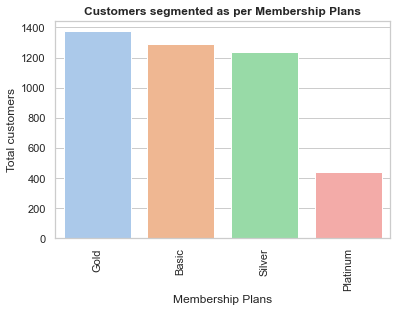

In [57]:
tiers = rfm2.Membership.value_counts().sort_values(ascending=False) 
sns.set_theme(style="whitegrid", palette='pastel')
sns.barplot(x=tiers.iloc[0:10].index, y=tiers.iloc[0:10].values)
plt.xticks(rotation=90)
plt.ylabel('Total customers')
plt.xlabel('Membership Plans')
plt.title('Customers segmented as per Membership Plans',fontweight='bold')
plt.show()

Assigning memberships solely on the basis of the RFMScore doesnot seem to be right as it is not a good method to ensure that the customers with Platinum or Silver would be shopping quite often from the online retail. We would need to look into further details to see their shopping habits.

### 2) Plotting  the count of customers in each RFM Segment

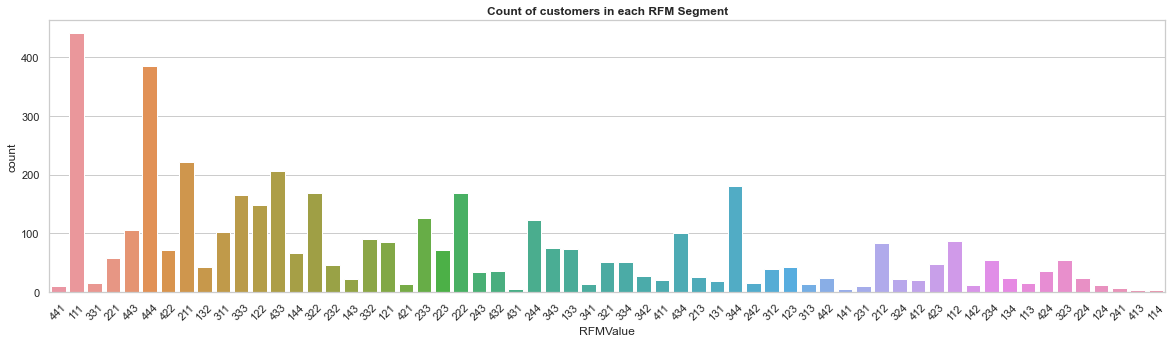

In [58]:
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 5))
sns.countplot(x="RFMValue", data=rfm2)
plt.xticks(rotation=45)
plt.title('Count of customers in each RFM Segment',fontweight='bold')
plt.show()

From the plot above we can see that a high majority of the customers of the online retail fall in '111' category, making themselves the best customers for the retail. Also, the second highest majority of customers are falling in the '444'  category making them the worst customers. The retail needs to focus its shift on the customers with '111' score and have targeted market advertising to increase sales.

### 3) Customers segmented as per their RFM Score

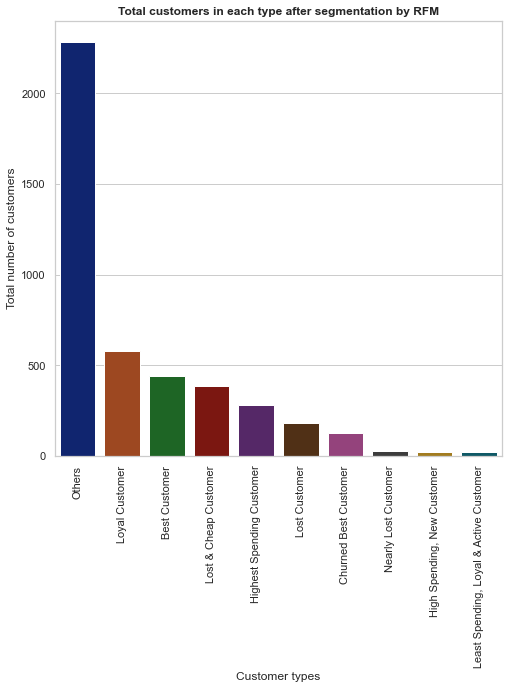

In [59]:
g=rfm2['Label'].value_counts()
plt.figure(figsize=(8, 8))
plt.xticks(rotation=90)
sns.barplot(x=g.iloc[0:10].index, y=g.iloc[0:10].values,palette = "dark")
plt.ylabel('Total number of customers')
plt.xlabel('Customer types')
plt.title('Total customers in each type after segmentation by RFM',fontweight='bold')
plt.show()

From the plot above we can see that the online retail has quite a lot of Loyal Customers as well as Best Customers. It can choose to focus on these customers by provided them with deals. Also, the retail store needs to reduce utilizing it's resources on the lost and cheap customers who are frugal in their purchase

### 4) Best Customers 

In [60]:
dat=rfm2[rfm2['RFMValue']=='111'].sort_values('MScore', ascending=False)
n=pd.merge(data, dat, on = "CustomerID", how = "inner")
n['Country'].value_counts()

United Kingdom    146950
EIRE                7077
France              3917
Germany             3662
Netherlands         2080
Portugal             784
Belgium              560
Norway               420
Switzerland          354
Sweden               198
Iceland              182
Spain                 23
Name: Country, dtype: int64

The best customers of the online retail store belong majorly from United Kingdom itself and its neighbouring European countries like France, Germany, Netherlands and Portugal.

## Customer Segmentation using k means clustering


K-means clustering is a technique used to cluster customers. The clustering technique can be based on geographical information, demographic information or lifestyle information. In this case, we will segment customers as per the RFM score and assign them a cluster.


K means clustering can help a business by helping them to customize their campaigns and advertising. It will also help the business decide which group of customers need to be targeted for a new product.

In [61]:
RFM = rfm2[['Recency','Frequency','Monetary']]
RFM.head()

,Recency,Frequency,Monetary
0,325,1,77183.60
1,2,182,4310.00
2,75,31,1797.24
3,18,73,1757.55
4,310,17,334.40


#### Heatmap

<AxesSubplot:>

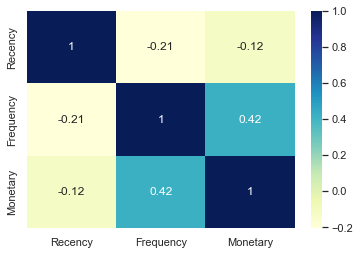

In [62]:
sns.heatmap(RFM.corr(), cmap="YlGnBu", annot=True)

The heatmap shows a positive correlation between Frequency and Monetary. It implies that as the frequency of purchase increases, the monetary value increases as well.Also, there is a negative relation between Frequency and Recency which indicates that if the frequency of purchase decreases then the recency also decreases.

### Skewness in data for RFM Table

The need to check for skewness in data is because k means clustering only works for data which is not skewed. Skewness refers to the distortion that deviates from the normal distribution.

In [63]:
RFM.skew(axis = 0, skipna = True)# checking for skewness in data

Recency       1.246137
Frequency    18.106243
Monetary     19.326985
dtype: float64

The data seems to be highly skewed. The skewness is maximum for Monetary column.

From the plots for Recency, Frequency and Monetary respectively we can understand the distribution properly.

#### Plot RFM distributions to look for skewness

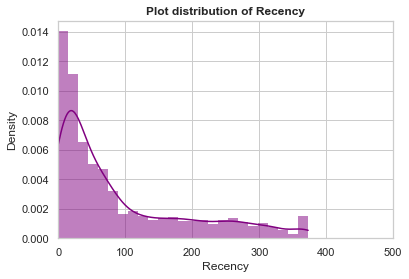

In [64]:
# Plot distribution of Recency
sns.histplot(RFM['Recency'],color='purple',kde=True, stat="density", linewidth=0)
plt.xlim(0,500)
plt.grid(True)
plt.title('Plot distribution of Recency',fontweight="bold")
plt.show()

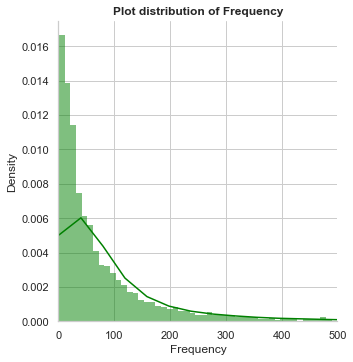

In [65]:
# Plot distribution of Frequency
sns.displot(RFM['Frequency'],color="green",kde=True, stat="density", linewidth=0)
plt.xlim(0,500)
plt.grid(True)
plt.title('Plot distribution of Frequency',fontweight="bold")
plt.show()

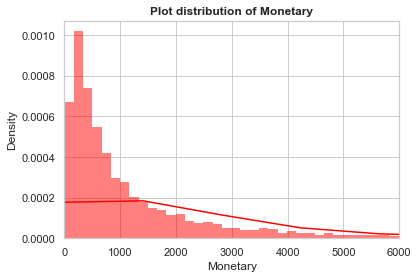

In [66]:
# Plot distribution of Monetary
sns.histplot(RFM['Monetary'],color="red",kde=True, stat="density", linewidth=0)
plt.xlim(0,6000)
plt.grid(True)
plt.title('Plot distribution of Monetary',fontweight="bold")
plt.show()

From the plots above we can see that the data is highly skewed. To reduce skewness of the data, we will perform log transformations to reduce the skewness of each variable.

### Normalization

As the dataset has values of Recency, Frequency and Monetary in different ranges, we will use normalization to bring the values to a common scale.

MinMaxScaler() is a normalization technique used to scale the data in the range of 0 to 1. The minimum value of feature gets scaled down to 0 and the maximum value of a feature is scaled to 1.

In [67]:
scaler = MinMaxScaler()#to normalize the input variables
x_scaled = scaler.fit_transform(RFM)#to scale the training data and  learn the scaling parameters of RFM data
scaled_data = pd.DataFrame(x_scaled,columns=RFM.columns)

In [68]:
scaled_data.head()

,Recency,Frequency,Monetary
0,0.871314,0.000000,0.275453
1,0.005362,0.023069,0.015382
2,0.201072,0.003824,0.006414
3,0.048257,0.009177,0.006272
4,0.831099,0.002039,0.001193


#### Plots of Recency, Frequency and Monetary after normalizing the dataset

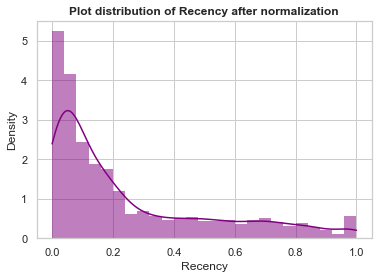

In [69]:
# Plot distribution of Recency
sns.histplot(scaled_data['Recency'],color="purple",kde=True, stat="density", linewidth=0)
plt.grid(True)
plt.title('Plot distribution of Recency after normalization',fontweight="bold")
plt.show()

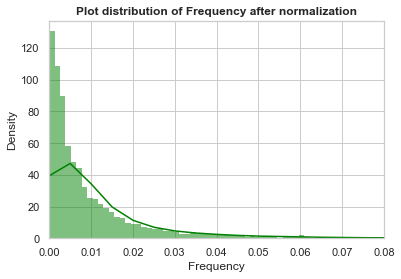

In [70]:
# Plot distribution of Frequency
sns.histplot(scaled_data['Frequency'],color="green",kde=True, stat="density", linewidth=0)
plt.xlim(0,0.08)
plt.grid(True)
plt.title('Plot distribution of Frequency after normalization',fontweight="bold")
plt.show()

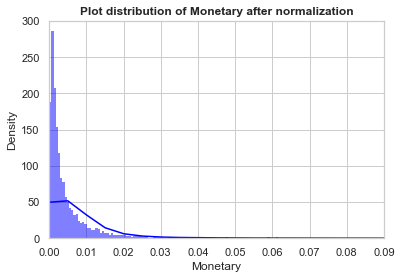

In [71]:
#Plot distribution of Monetary
sns.histplot(scaled_data['Monetary'],color="blue",kde=True, stat="density", linewidth=0)
plt.xlim(0,0.09)
plt.grid(True)
plt.title('Plot distribution of Monetary after normalization',fontweight="bold")
plt.show()

From the above 3 plots, it is seen that the data has been normalized for all three parameters.

### Elbow Method

Elbow method is used to determine the number of clusters required for the dataset.

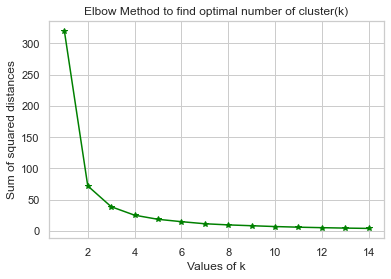

In [72]:
X = np.asarray(scaled_data)
dist = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    dist.append(km.inertia_)
plt.plot(K, dist,marker="*",c="green")
plt.xlabel('Values of k')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method to find optimal number of cluster(k)')
plt.show()

From the elbow plot we can see that the optimal number for k is 4. Thus, there will be 4 clusters.

In [73]:
kmeans = KMeans(n_clusters = 4, init='k-means++', n_init =10,max_iter = 300)
kmeans.fit(scaled_data)
pred = kmeans.predict(scaled_data)
y_kmeans = kmeans.predict(scaled_data)

#### Silhouette Score

Silhouette score range from -1 to +1 and evaluates the quality of clusters created by the algorithm.A score close to +1 indicates good clustering model and a score close to -1 indicates a poor clustering model.


In [74]:
score = silhouette_score (scaled_data, kmeans.labels_)
print('Silhouette Score=' , score)

Silhouette Score= 0.5770367168753653


In [75]:
# group by cluster
cluster_table = RFM.assign(Cluster=kmeans.labels_)

#### Average RFM values for each cluster

In [76]:
# average RFM values for each cluster
cluster_table.groupby(['Cluster']).mean()

,Recency,Frequency,Monetary
Cluster,,,
0,83.823529,51.886210,1014.687408
1,193.018395,34.443144,721.201958
2,19.800634,141.265519,3237.989697
3,308.486922,23.637827,566.710322


In [77]:
df1 = pd.DataFrame(rfm2)
rfm2['cluster'] = y_kmeans
rfm2.tail()

,index,CustomerID,Recency,Frequency,Monetary,RScore,FScore,MScore,RFMValue,RFMScore,Membership,Label,cluster
4334,4334,18280.0,277,10,180.60,4,4,4,444,12,Basic,Lost & Cheap Customer,3
4335,4335,18281.0,180,7,80.82,4,4,4,444,12,Basic,Lost & Cheap Customer,1
4336,4336,18282.0,7,12,178.05,1,4,4,144,9,Gold,Others,2
4337,4337,18283.0,3,756,2094.88,1,1,1,111,3,Platinum,Best Customer,2
4338,4338,18287.0,42,70,1837.28,2,2,1,221,5,Silver,Highest Spending Customer,2


#### Total customers in each cluster

In [78]:
rfm2['cluster'].value_counts()

2    2207
0    1037
1     598
3     497
Name: cluster, dtype: int64

#### Conclusion

Cluster 0 has 2231 customers which makes it the group with highest number of customers. It has 51.04% of total customers. It comprises of the group of customers that spend the most and are best customers. It includes a few other customers as well.


Cluster 1 has 497 customers which makes it the group with lowest number of customers. It has 11.45% of total customers. It denotes the group of certain lost and cheap customers as well as nearly lost customers.They make the transactions of small amounts.


Cluster 2 has 1013 customers which makes it the second largest group in terms of number of customers. It has 23.34% of total customers. It denotes the group which makes big transactions and comprises of loyal customers as well.


Cluster 3 has 598 customers which makes it the group with lowest number of customers. It has 13.78% of total customers. It denotes the group of customers who visit frequently but are making average transactions. It also comprises of churned best customers.

## Market Basket Analysis by Apriori Algorithm

The Apriori Algorithm makes use of frequently bought items to make association rules and helps to determine how strongly or weakly two objects are connected. In our case, it can help us to understand and find the products which can be bough together.

In [79]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

As the number of products purchased were highest for United Kingdom, we will focus on it specifically.

In [80]:
uk = data[data['Country']=='United Kingdom']# picking up the data which has entries for country as United Kingdom
print('Unique products in dataset:',uk['Description'].nunique())

Unique products in dataset: 3844


In [81]:
item_count = uk.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack()
item_count=item_count.reset_index()
item_count=item_count.fillna(0).set_index('InvoiceNo')
item_count.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


A apriori() only accepts one hot encoded dataframes, we will have to perform the same on our dataset.

In [82]:
#function for one hot encoding
def encode(val):
    if val > 0:
        return 1 #represents customer has purchased it
    else:
        return 0 #represents customer didn't purchase it

In [83]:
basket = item_count.applymap(encode)#apply function encode
basket.head()

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Support

Support gives us information about the number of times a product has been purchased throughout all transactions.

In [84]:
products = apriori(basket, min_support=0.02, use_colnames=True).sort_values('support', ascending=False) #calling apriori algorithm
products

,support,itemsets
184,0.113160,(WHITE HANGING HEART T-LIGHT HOLDER)
79,0.086912,(JUMBO BAG RED RETROSPOT)
149,0.084690,(REGENCY CAKESTAND 3 TIER)
11,0.078083,(ASSORTED COLOUR BIRD ORNAMENT)
123,0.077542,(PARTY BUNTING)
...,...,...
117,0.020121,(PAINTED METAL PEARS ASSORTED)
221,0.020061,"(LUNCH BAG SPACEBOY DESIGN , LUNCH BAG PINK PO..."
42,0.020061,(FELTCRAFT PRINCESS LOLA DOLL)
222,0.020001,"(LUNCH BAG SUKI DESIGN , LUNCH BAG PINK POLKADOT)"


In [85]:
#filtering items with length greater than 3 which indicates that they had been purchased together
products['length'] = products['itemsets'].apply(lambda x: len(x))
products.head()
display(products[products['length'] >= 3])

,support,itemsets,length
234,0.020482,"(PINK REGENCY TEACUP AND SAUCER, ROSES REGENCY...",3


For association rules, metric can be either confidence or lift.

#### Confidence

It gives us information about the likeliness of a product being purchased if another product is being purchased. e.g. if product A was purchased then how likely is it that product B will be bought?

In [86]:
conf = association_rules(products, metric="confidence", min_threshold=0.5)
conf.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.048772,0.086912,0.030392,0.623153,7.169917,0.026153,2.422965
1,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.040723,0.036759,0.028590,0.702065,19.099148,0.027093,3.233057
2,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.036759,0.040723,0.028590,0.777778,19.099148,0.027093,4.316746
3,(LUNCH BAG PINK POLKADOT),(LUNCH BAG RED RETROSPOT),0.050934,0.067271,0.028290,0.555425,8.256485,0.024864,2.098021
4,(GARDENERS KNEELING PAD KEEP CALM ),(GARDENERS KNEELING PAD CUP OF TEA ),0.044567,0.037660,0.027509,0.617251,16.390122,0.025831,2.514283


#### Lift

Lift gives information about how likely are items bought together as compared to being purchased individually.

In [87]:
rule = association_rules(products, metric="lift", min_threshold=1)
rule.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.086912,0.048772,0.030392,0.349689,7.169917,0.026153,1.462728
1,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.048772,0.086912,0.030392,0.623153,7.169917,0.026153,2.422965
2,(LUNCH BAG RED RETROSPOT),(LUNCH BAG BLACK SKULL.),0.067271,0.059823,0.029071,0.432143,7.223641,0.025046,1.655657
3,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.059823,0.067271,0.029071,0.485944,7.223641,0.025046,1.814449
4,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.040723,0.036759,0.028590,0.702065,19.099148,0.027093,3.233057


From the table above we can see that if ALARM CLOCK BAKELIKE GREEN is purchased then ALARM CLOCK BAKELIKE RED will also be purchased. The table groups up all the items which have a possibility of being purchased together.

#### Lift and Confidence

In [88]:
# products that will mostly be purchased together
rule[(rule['lift'] >= 5) & (rule['confidence']>= 0.5)] 

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.048772,0.086912,0.030392,0.623153,7.169917,0.026153,2.422965
4,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.040723,0.036759,0.028590,0.702065,19.099148,0.027093,3.233057
5,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.036759,0.040723,0.028590,0.777778,19.099148,0.027093,4.316746
7,(LUNCH BAG PINK POLKADOT),(LUNCH BAG RED RETROSPOT),0.050934,0.067271,0.028290,0.555425,8.256485,0.024864,2.098021
8,(GARDENERS KNEELING PAD KEEP CALM ),(GARDENERS KNEELING PAD CUP OF TEA ),0.044567,0.037660,0.027509,0.617251,16.390122,0.025831,2.514283
9,(GARDENERS KNEELING PAD CUP OF TEA ),(GARDENERS KNEELING PAD KEEP CALM ),0.037660,0.044567,0.027509,0.730463,16.390122,0.025831,3.544712
10,(WOODEN PICTURE FRAME WHITE FINISH),(WOODEN FRAME ANTIQUE WHITE ),0.051294,0.047090,0.027509,0.536300,11.388845,0.025094,2.055013
11,(WOODEN FRAME ANTIQUE WHITE ),(WOODEN PICTURE FRAME WHITE FINISH),0.047090,0.051294,0.027509,0.584184,11.388845,0.025094,2.281550
12,(ALARM CLOCK BAKELIKE RED ),(ALARM CLOCK BAKELIKE GREEN),0.045528,0.041444,0.027269,0.598945,14.451925,0.025382,2.390084
13,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED ),0.041444,0.045528,0.027269,0.657971,14.451925,0.025382,2.790617


The above table gives us information about products that will most likely be purchased together.